In [1]:
from pathlib import Path
import pandas as pd
import regex as re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Experiment on Local Mode

## Independent Variable
* ```ncores: [4, 8, 16, 32]```
* ```workload: [daa, dpp]```
* ```node: [gl6]```

## Dependent Variable:

* ```Energy Consumption (MJ)```
* ```Execution Time (hours)```
* ```Memory Utilization - AveRSS (MB)```

In [2]:
# Functions for parsing the files
def extract_workflow(df):
    # This function gets the entries referring to batches
    # and extracts the corresponding workflow from the job entry
    batches = df[df['JobID'].str.contains('batch', regex=True)]

    for i, row in batches.iterrows():
        jobid = row.JobID.split('.')[0] # extracts di ID
        # find the job entry in the dataframe including all the entries
        jobrow = df[df['JobID'] == jobid]
        # extract the workflow from job name
        workflow = jobrow['JobName'].item().split('-')[0]
        
        # substitute JobName with the workflow
        row['JobName'] = workflow
        row['JobID'] = jobid

    return batches.rename(columns={'JobName': 'Workflow'})

def parse(path):
    df = pd.read_csv(path, header=None, delimiter=r"\s+")
    df.columns =  list(df.loc[0]) # set headers
    # gets completed entries
    df = df[(df['State'] == 'COMPLETED')]
    
    return extract_workflow(df)

def read_dataset(files):
    dfs = [parse(f) for f in files]
    
    return pd.concat(dfs, ignore_index=True)

In [3]:
# Functions for performing Statistical Tests
import scipy.stats as stats
from scipy.stats import f_oneway
from scipy.stats import shapiro
from statistics import mean

pd.set_option('mode.chained_assignment', None)

def improvement(original_value, new_value):
    improvement_percentage = ((new_value - original_value) / abs(original_value)) * 100
    return improvement_percentage

# Code taken from
# https://stats.stackexchange.com/questions/67926/understanding-the-one-way-anova-effect-size-in-scipy

def effect_size(*args):
    """ Return the eta squared as the effect size for ANOVA"""    
    return float(ss_between(*args) / ss_total(*args))

def ss_total(*args):
    vec = concentrate(*args)
    ss_total = sum((vec - np.mean(vec))**2)

    return ss_total

def ss_between( *args):
    # grand mean
    grand_mean = np.mean(concentrate(*args))

    ss_btwn = 0
    for a in args:
        ss_btwn += (len(a) * (np.mean( a) - grand_mean) **2)

    return ss_btwn

def ss_within(*args):
    return ss_total(*args) - ss_between(*args)

def concentrate(*args):
    v = list(map(np.asarray, args))
    vec = np.hstack(np.concatenate(v))
    return vec

def normality_check(samples, x_label="", y_label=""):
    # Set Grid for the plots
    fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20, 10))

    c = 0
    i = 0

    # Normality Check using Shapiro-Wilk
    for x, y in samples.items():
        stat, p = shapiro(y)
        print('NCORES:', x, '\tSTAT:', stat, '\tp-value:', p)

        # Generate a Violin Plot
        ax = sns.violinplot(data=y, ax=axs[i][c]) 
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.set_xticklabels([x])
        c += 1

        if c > 1:
            i += 1
            c = 0

In [4]:
# Import Dataset
data_dir = "./exp-local"

## RQ - What is the impact of the ncores parameter on energy consumption and performance?

In [5]:
files = Path(data_dir).glob('*gl6*.txt')
data = read_dataset(files)

In [6]:
data.head()

,JobID,Workflow,Cluster,NodeList,State,Start,End,ConsumedEnergy,AveRSS,AveDiskRead,AveDiskWrite,AveVMSize,Elapsed,NCPUS
0,43495,daa,gl2_gl4,gl6,COMPLETED,2023-12-15T18:33:31,2023-12-16T04:35:09,4.81M,2609484K,88378.65M,12751.49M,52572120K,10:01:38,8
1,43498,dpp,gl2_gl4,gl6,COMPLETED,2023-12-16T04:40:13,2023-12-16T05:22:24,326.97K,1172832K,5345.23M,804.96M,50595888K,00:42:11,8
2,43501,dpp,gl2_gl4,gl6,COMPLETED,2023-12-16T05:27:27,2023-12-16T06:09:53,328.61K,1168356K,5345.24M,805.04M,50494440K,00:42:26,8
3,43510,daa,gl2_gl4,gl6,COMPLETED,2023-12-16T18:04:16,2023-12-17T04:13:49,4.84M,2640956K,88354.40M,12749.19M,52570952K,10:09:33,8
4,43513,dpp,gl2_gl4,gl6,COMPLETED,2023-12-17T04:18:55,2023-12-17T04:46:49,232.06K,2187452K,5345.24M,805.05M,98666132K,00:27:54,16


In [7]:
def convert_to_hours(time_str):
    d = 0
    
    if '-' in time_str:
        d = time_str.split('-')
        time_str = d[1]
        d = int(d[0])
    
    h, m, s = list(map(int, time_str.split(':')))
    total_hours = h + m / 60 + s / 3600
    
    return total_hours + (d * 24)

def remove_unit(string):
    if 'M' in string:
        return string.replace('M', '')
    # elif 'K' in string:
    return string.replace('K', '')

def convert_to_gb(memory_str):
    return float(remove_unit(memory_str)) * (10**-6)

def convert_to_mega_joule(energy_str):
    return remove_unit(energy_str)

def get_data(data, workflow="daa", column="Elapsed"):
    output = data[data['Workflow'] == workflow][[column, 'NCPUS']]

    # Clean Data
    if column == "ConsumedEnergy":
        output[column] = output[column].apply(convert_to_mega_joule)
    elif column == "AveRSS":
        output[column] = output[column].apply(convert_to_gb)
    elif column == "Elapsed":
        output[column] = output[column].apply(convert_to_hours)

    # Convert Data
    return output.astype({column: float, "NCPUS": int})

### Energy Consumption 

#### DAA

In [8]:
daa_energy = get_data(data, workflow='daa', column='ConsumedEnergy')

In [9]:
# Descriptive Statistics
daa_energy.groupby('NCPUS').agg(['mean', 'std', 'var'])

ConsumedEnergy                    
                mean       std       var
NCPUS                                   
2          12.750000       NaN       NaN
4           7.558000  0.042374  0.001796
8           4.762727  0.054606  0.002982
16          3.192000  0.033928  0.001151
32          2.707000  0.022136  0.000490

In [10]:
# Pearson correlation Between NCORES and Energy Consumption
print(
    "Pearson Correlation:", 
    daa_energy['NCPUS'].corr(daa_energy['ConsumedEnergy'])
)

Pearson Correlation: -0.7748707447910634


In [11]:
# Obtaining the samples (daa, 4) (daa, 8) .. (daa, 32)
samples = {
    x : list(daa_energy[daa_energy['NCPUS'] == x]['ConsumedEnergy']) for x in [4, 8, 16, 32]
}

NCORES: 4 	STAT: 0.8624092936515808 	p-value: 0.08146137744188309
NCORES: 8 	STAT: 0.8761255741119385 	p-value: 0.09287411719560623
NCORES: 16 	STAT: 0.8718368411064148 	p-value: 0.10501144826412201
NCORES: 32 	STAT: 0.7524783611297607 	p-value: 0.003825535299256444


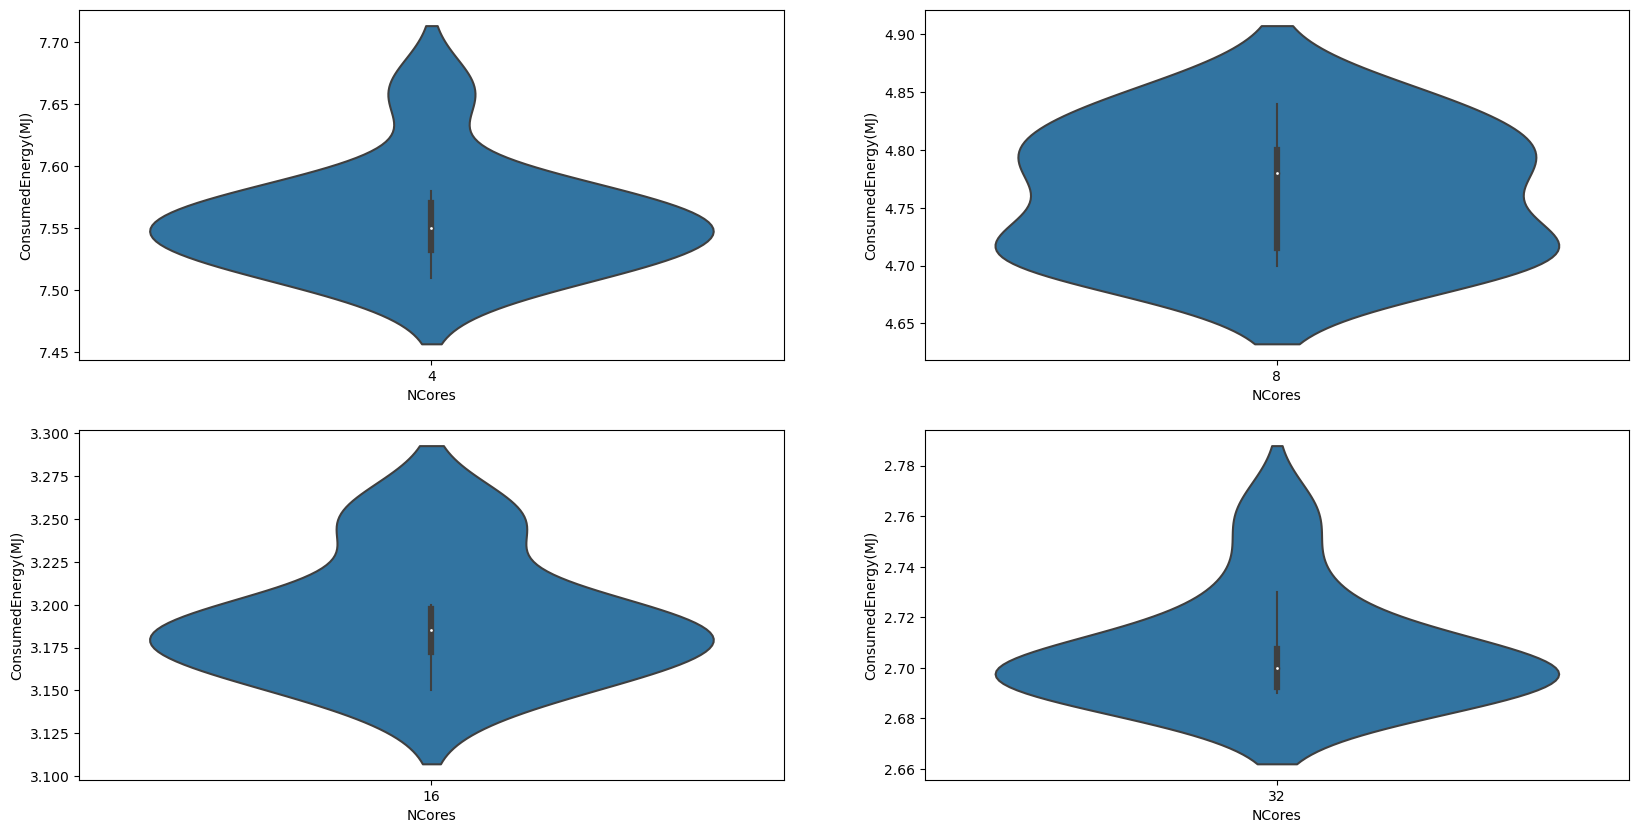

In [12]:
normality_check(samples, x_label='NCores', y_label='ConsumedEnergy(MJ)')

In [13]:
# homoscedasticity Levene's Test
statistic, p_value = stats.levene(*list(samples.values()))
print("stat:", statistic, "p_value:", p_value)

stat: 2.8235537745699277 p_value: 0.05198792258942086


In [14]:
# One-Way Anova Test
f_stat, p_value = f_oneway(*list(samples.values()))
print("f_stat:", statistic, "p_value:", p_value)

f_stat: 2.8235537745699277 p_value: 1.95608565828491e-62


In [15]:
# Effect Size using Eta Squared
effect_size(*list(samples.values()))

0.9995765000932892

In [16]:
# Average Improvement
average_energy = [mean(x) for x in samples.values()]
improvement(average_energy[0], average_energy[-1])

-64.1836464673194

#### DPP

In [17]:
dpp_energy = get_data(data, workflow='dpp', column='ConsumedEnergy')

In [18]:
# Descriptive Statistics
dpp_energy.groupby('NCPUS').agg(['mean', 'std', 'var'])

ConsumedEnergy                     
                mean       std        var
NCPUS                                    
2            826.350       NaN        NaN
4            514.615  4.816701  23.200606
8            323.648  3.644685  13.283729
16           226.368  3.723185  13.862107
32           198.764  2.881991   8.305871

In [19]:
# Pearson correlation Between NCORES and Energy Consumption
print(
    "Pearson Correlation:", 
    dpp_energy['NCPUS'].corr(dpp_energy['ConsumedEnergy'])
)

Pearson Correlation: -0.7727246451968413


In [20]:
# Obtaining the samples (daa, 4) (daa, 8) .. (daa, 32)
samples = {
    x : list(dpp_energy[dpp_energy['NCPUS'] == x]['ConsumedEnergy']) for x in [4, 8, 16, 32]
}

NCORES: 4 	STAT: 0.8529692888259888 	p-value: 0.06300633400678635
NCORES: 8 	STAT: 0.8045158982276917 	p-value: 0.01645064540207386
NCORES: 16 	STAT: 0.8855656981468201 	p-value: 0.1510733813047409
NCORES: 32 	STAT: 0.8386011123657227 	p-value: 0.042453259229660034


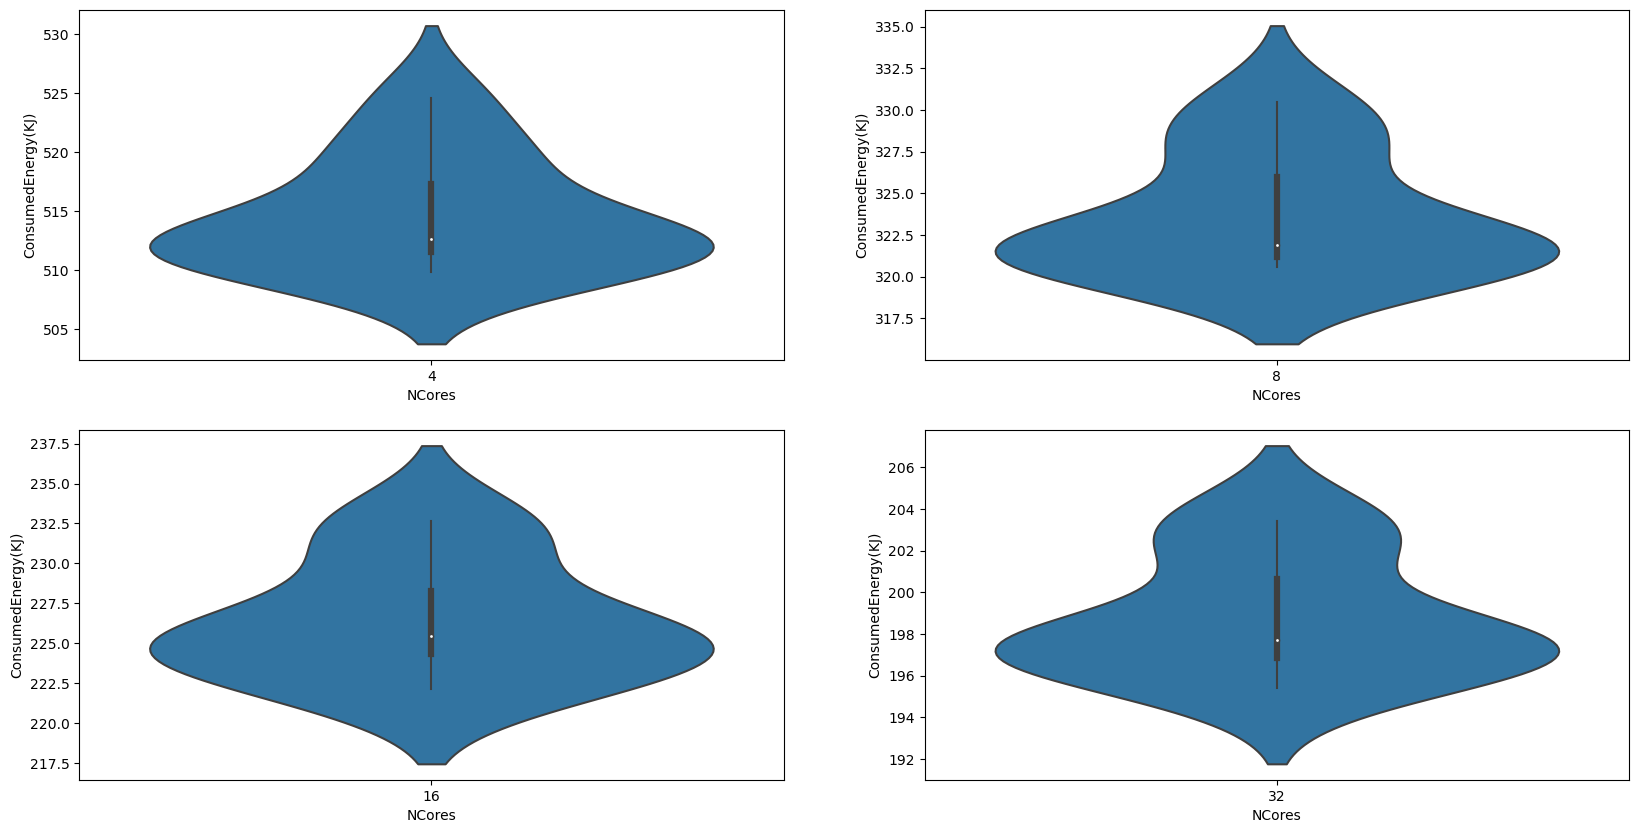

In [21]:
normality_check(samples, x_label='NCores', y_label='ConsumedEnergy(KJ)')

In [22]:
# homoscedasticity Levene's Test
statistic, p_value = stats.levene(*list(samples.values()))
print("stat:", statistic, "p_value:", p_value)

stat: 0.4253910089350368 p_value: 0.7359729086053282


In [23]:
# One-Way Anova Test
f_stat, p_value = f_oneway(*list(samples.values()))
print("f_stat:", statistic, "p_value:", p_value)

f_stat: 0.4253910089350368 p_value: 3.275323339562959e-55


In [24]:
# Effect Size using Eta Squared
effect_size(*list(samples.values()))

0.9991393964601775

In [25]:
# Average Improvement
average_energy = [mean(x) for x in samples.values()]
improvement(average_energy[0], average_energy[-1])

-61.37617442165503

### Execution Time

#### DAA

In [26]:
daa_time = get_data(data, workflow='daa', column='Elapsed')

In [27]:
# Descriptive Statistics
daa_time.groupby('NCPUS').agg(['mean', 'std', 'var'])

Elapsed                    
            mean       std       var
NCPUS                               
2      33.433611       NaN       NaN
4      17.266889  0.096293  0.009272
8       9.921616  0.145312  0.021116
16      5.908861  0.082972  0.006884
32      4.646694  0.065511  0.004292

In [28]:
# Pearson correlation Between NCORES and Execution Time
print(
    "Pearson Correlation:", 
    daa_time['NCPUS'].corr(daa_time['Elapsed'])
)

Pearson Correlation: -0.754864960230925


In [29]:
# Obtaining the samples (daa, 4) (daa, 8) .. (daa, 32)
samples = {
    x : list(daa_time[daa_time['NCPUS'] == x]['Elapsed']) for x in [4, 8, 16, 32]
}

NCORES: 4 	STAT: 0.8794687390327454 	p-value: 0.12867243587970734
NCORES: 8 	STAT: 0.9246911406517029 	p-value: 0.3596668541431427
NCORES: 16 	STAT: 0.8138996958732605 	p-value: 0.021379802376031876
NCORES: 32 	STAT: 0.8761342167854309 	p-value: 0.11777540296316147


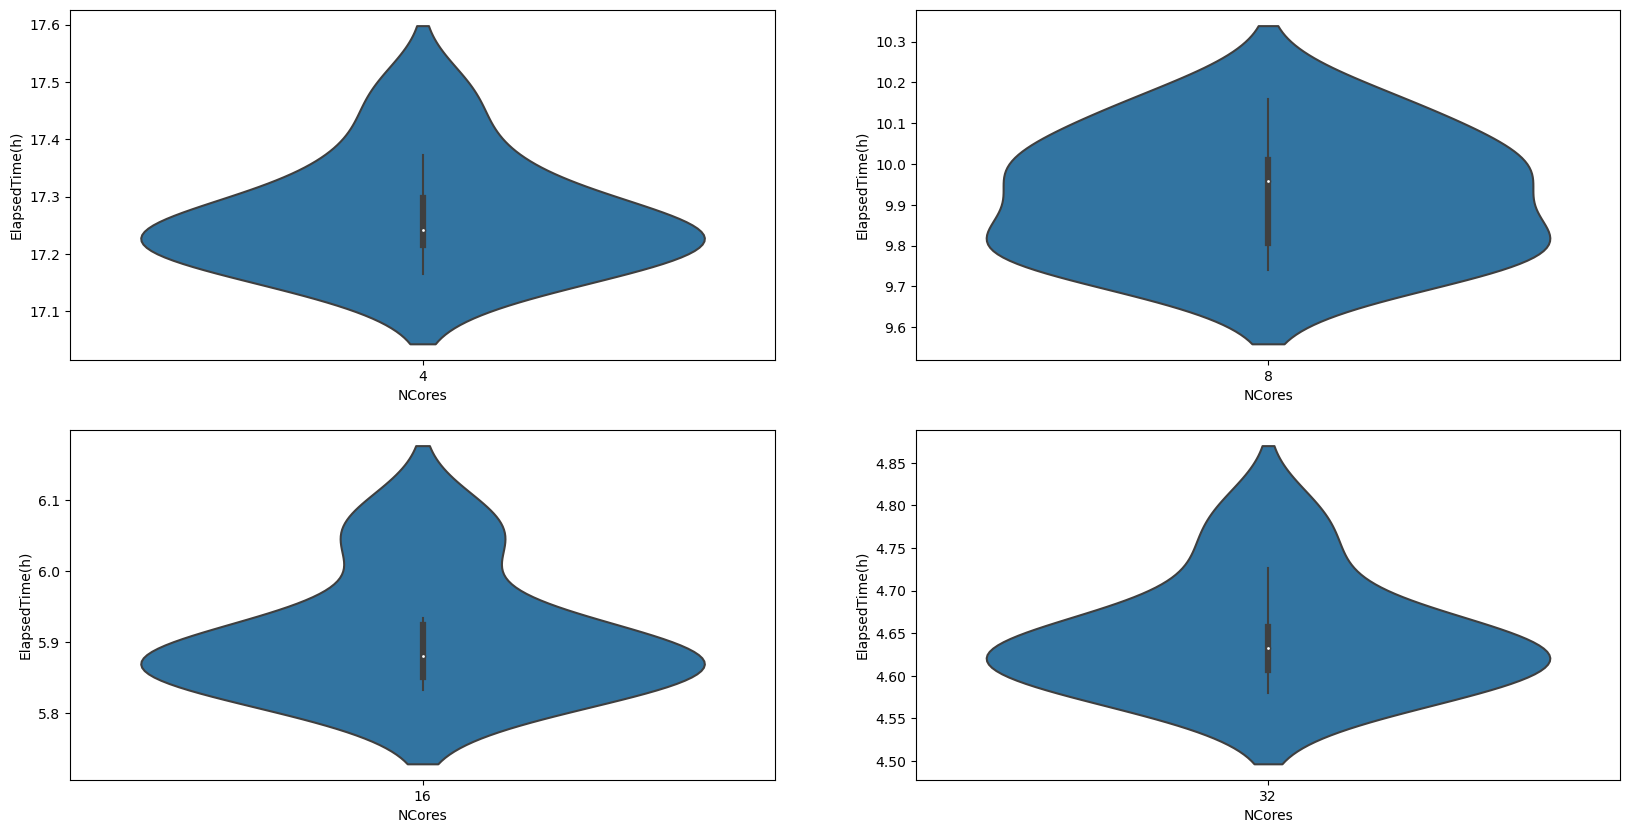

In [30]:
normality_check(samples, x_label='NCores', y_label='ElapsedTime(h)')

In [31]:
# Average Improvement
average_energy = [mean(x) for x in samples.values()]
improvement(average_energy[0], average_energy[-1])

-73.08898855870581

#### DPP

In [32]:
dpp_time = get_data(data, workflow='dpp', column='Elapsed')

In [33]:
# Descriptive Statistics
dpp_time.groupby('NCPUS').agg(['mean', 'std', 'var'])

Elapsed                    
           mean       std       var
NCPUS                              
2      2.351944       NaN       NaN
4      1.218667  0.020588  0.000424
8      0.695611  0.010945  0.000120
16     0.445556  0.014224  0.000202
32     0.358028  0.009067  0.000082

In [34]:
# Pearson correlation Between NCORES and Execution Time
print(
    "Pearson Correlation:", 
    dpp_time['NCPUS'].corr(dpp_time['Elapsed'])
)

Pearson Correlation: -0.7471086386840046


In [35]:
samples = {
    x : list(dpp_time[dpp_time['NCPUS'] == x]['Elapsed']) for x in [4, 8, 16, 32]
}

NCORES: 4 	STAT: 0.8233646154403687 	p-value: 0.027829403057694435
NCORES: 8 	STAT: 0.8124135732650757 	p-value: 0.020511379465460777
NCORES: 16 	STAT: 0.8661661744117737 	p-value: 0.09016764909029007
NCORES: 32 	STAT: 0.8841363191604614 	p-value: 0.1455181986093521


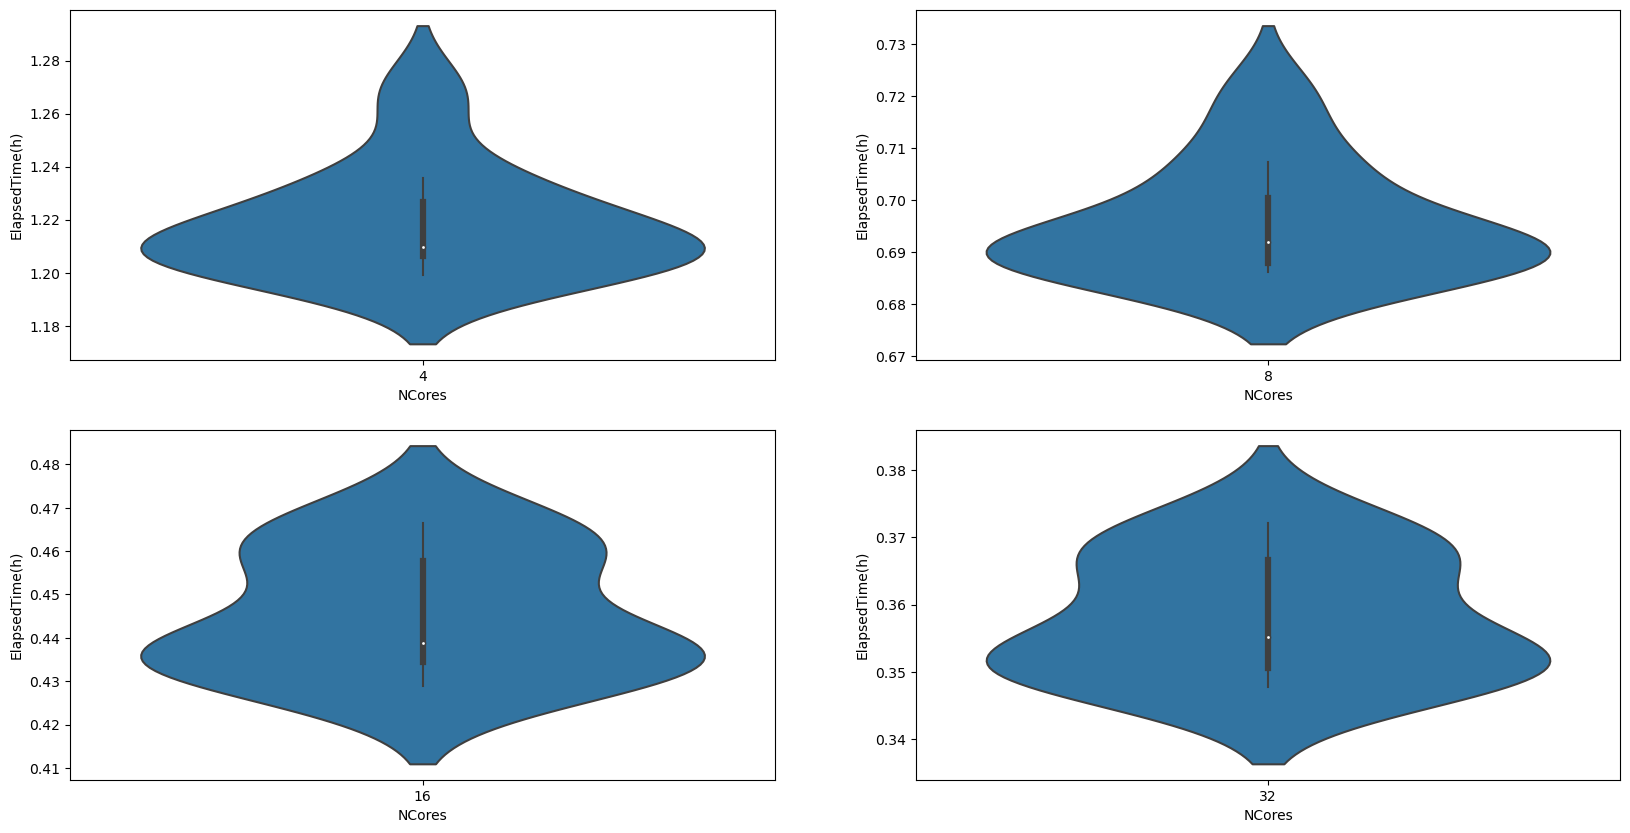

In [36]:
normality_check(samples, x_label='NCores', y_label='ElapsedTime(h)')

In [37]:
# Average Improvement
average_energy = [mean(x) for x in samples.values()]
improvement(average_energy[0], average_energy[-1])

-70.6213530269876

### Memory Usage

#### DAA

In [38]:
daa_memory = get_data(data, workflow='daa', column='AveRSS')

In [39]:
daa_memory.head()

,AveRSS,NCPUS
0,2.609484,8
3,2.640956,8
5,2.605864,8
7,2.601644,8
10,1.917584,4


In [40]:
# Descriptive Statistics
daa_memory.groupby('NCPUS').agg(['mean', 'std', 'var'])

AveRSS                    
           mean       std       var
NCPUS                              
2      0.889364       NaN       NaN
4      1.552179  0.192548  0.037075
8      2.629645  0.078819  0.006212
16     4.878790  0.006286  0.000040
32     9.456919  0.024110  0.000581

In [41]:
# Pearson correlation Between NCORES and Memory
print(
    "Pearson Correlation:", 
    daa_memory['NCPUS'].corr(daa_memory['AveRSS'])
)

Pearson Correlation: 0.9994356095199391


In [42]:
samples = {
    x : list(daa_memory[daa_memory['NCPUS'] == x]['AveRSS']) for x in [4, 8, 16, 32]
}

NCORES: 4 	STAT: 0.5314385890960693 	p-value: 8.515804438502528e-06
NCORES: 8 	STAT: 0.4698384404182434 	p-value: 6.587104053323856e-07
NCORES: 16 	STAT: 0.9494577050209045 	p-value: 0.6620887517929077
NCORES: 32 	STAT: 0.8346819877624512 	p-value: 0.03809473291039467


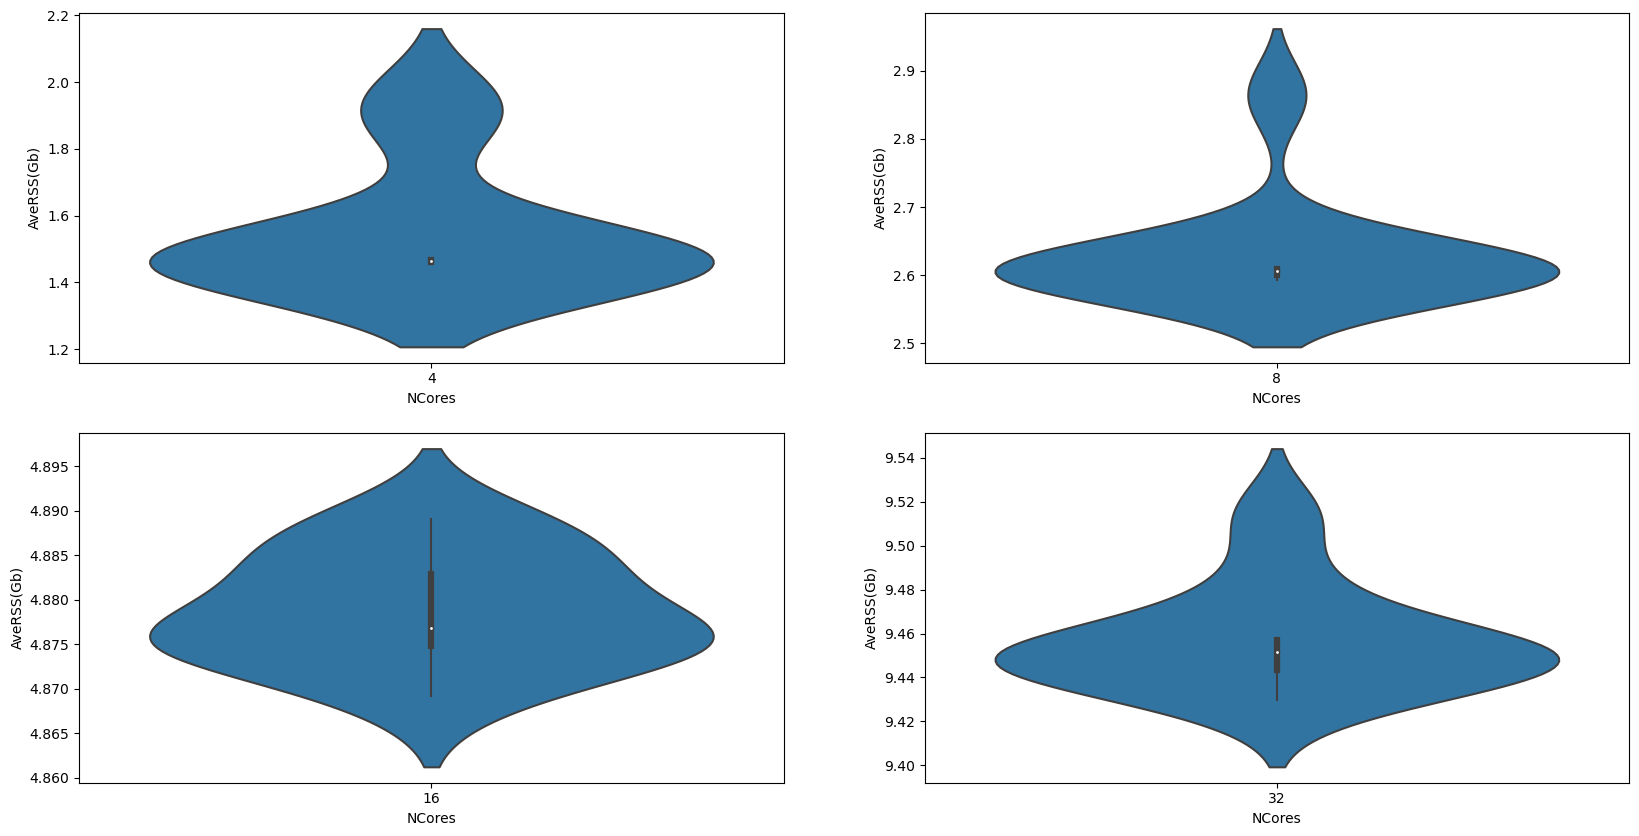

In [43]:
normality_check(samples, x_label='NCores', y_label='AveRSS(Gb)')

In [44]:
# Average Improvement
average_energy = [mean(x) for x in samples.values()]
improvement(average_energy[0], average_energy[-1])

509.2672289385144

#### DPP

In [45]:
dpp_memory = get_data(data, workflow='dpp', column='AveRSS')

In [46]:
dpp_memory.groupby('NCPUS').agg(['mean', 'std', 'var'])

AveRSS                    
           mean       std       var
NCPUS                              
2      0.398680       NaN       NaN
4      0.665799  0.009358  0.000088
8      1.177572  0.010036  0.000101
16     2.197242  0.007307  0.000053
32     3.928931  0.064277  0.004132

In [47]:
# Pearson correlation Between NCORES and Memory
print(
    "Pearson Correlation:", 
    dpp_memory['NCPUS'].corr(dpp_memory['AveRSS'])
)

Pearson Correlation: 0.9987382720462699


In [48]:
samples = {
    x : list(dpp_memory[dpp_memory['NCPUS'] == x]['AveRSS']) for x in [4, 8, 16, 32]
}

NCORES: 4 	STAT: 0.8786264061927795 	p-value: 0.12583374977111816
NCORES: 8 	STAT: 0.9293909072875977 	p-value: 0.4419277608394623
NCORES: 16 	STAT: 0.9231909513473511 	p-value: 0.3843395709991455
NCORES: 32 	STAT: 0.8746510744094849 	p-value: 0.11321312189102173


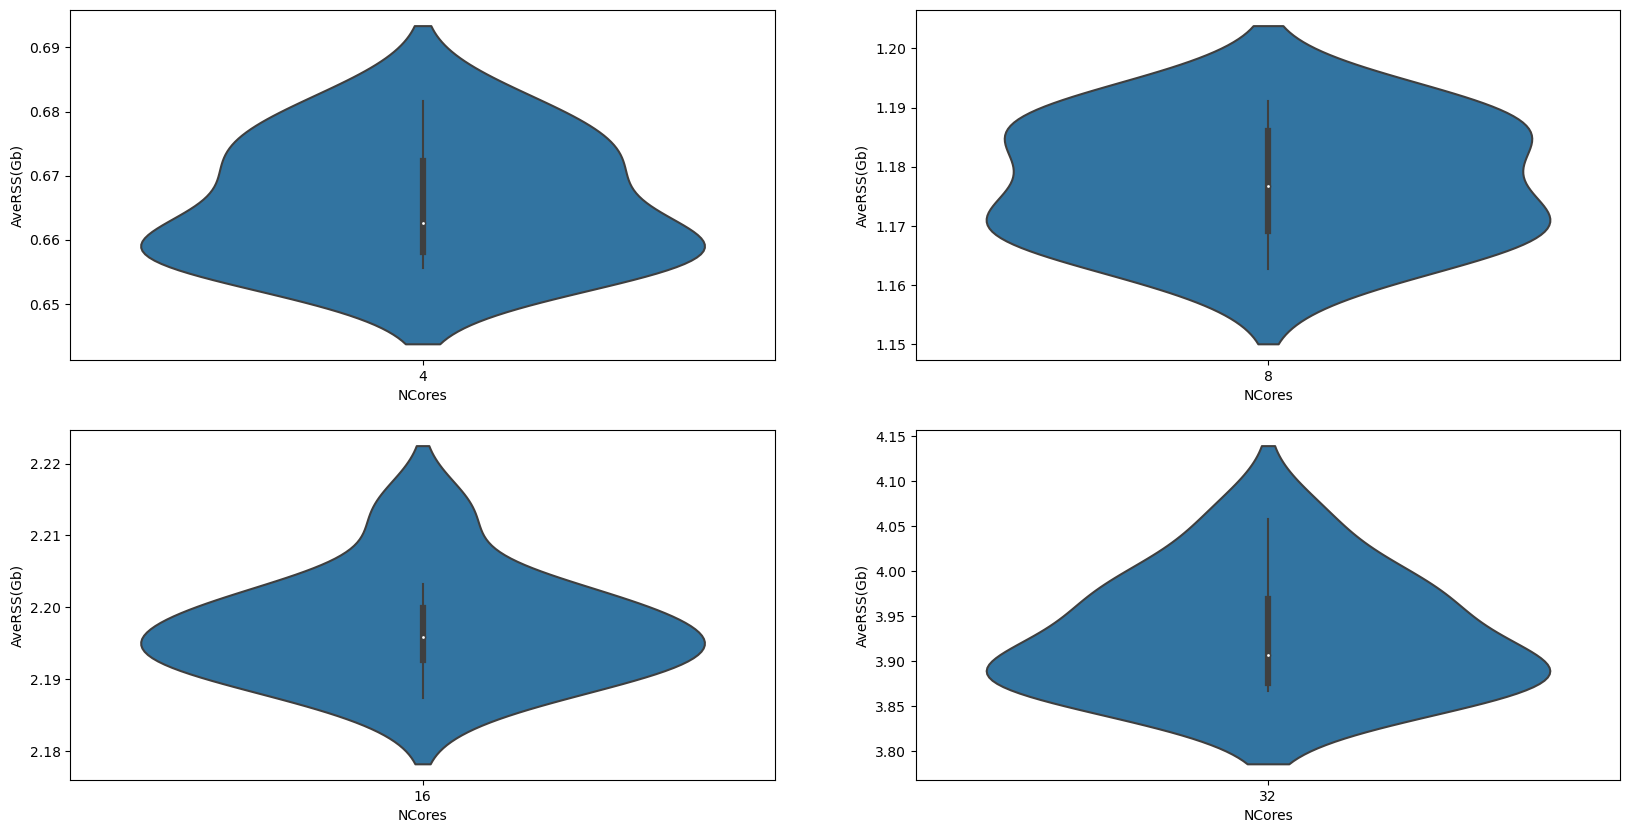

In [49]:
normality_check(samples, x_label='NCores', y_label='AveRSS(Gb)')

In [50]:
# Average Improvement
average_energy = [mean(x) for x in samples.values()]
improvement(average_energy[0], average_energy[-1])

490.10788244136216

In [51]:
data

,JobID,Workflow,Cluster,NodeList,State,Start,End,ConsumedEnergy,AveRSS,AveDiskRead,AveDiskWrite,AveVMSize,Elapsed,NCPUS
0,43495,daa,gl2_gl4,gl6,COMPLETED,2023-12-15T18:33:31,2023-12-16T04:35:09,4.81M,2609484K,88378.65M,12751.49M,52572120K,10:01:38,8
1,43498,dpp,gl2_gl4,gl6,COMPLETED,2023-12-16T04:40:13,2023-12-16T05:22:24,326.97K,1172832K,5345.23M,804.96M,50595888K,00:42:11,8
2,43501,dpp,gl2_gl4,gl6,COMPLETED,2023-12-16T05:27:27,2023-12-16T06:09:53,328.61K,1168356K,5345.24M,805.04M,50494440K,00:42:26,8
3,43510,daa,gl2_gl4,gl6,COMPLETED,2023-12-16T18:04:16,2023-12-17T04:13:49,4.84M,2640956K,88354.40M,12749.19M,52570952K,10:09:33,8
4,43513,dpp,gl2_gl4,gl6,COMPLETED,2023-12-17T04:18:55,2023-12-17T04:46:49,232.06K,2187452K,5345.24M,805.05M,98666132K,00:27:54,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,43243,dpp,gl2_gl4,gl6,COMPLETED,2023-12-15T09:29:41,2023-12-15T09:57:12,232.68K,2203256K,5341.92M,804.84M,98631928K,00:27:31,16
79,43246,dpp,gl2_gl4,gl6,COMPLETED,2023-12-15T10:02:14,2023-12-15T10:24:18,201.53K,3897232K,5342.72M,804.96M,193723732K,00:22:04,32
80,43249,dpp,gl2_gl4,gl6,COMPLETED,2023-12-15T10:29:23,2023-12-15T10:51:43,203.40K,3964100K,5341.96M,804.89M,193718664K,00:22:20,32
81,43252,daa,gl2_gl4,gl6,COMPLETED,2023-12-15T10:56:46,2023-12-15T16:59:07,3.25M,4878132K,88378.66M,12751.57M,102392860K,06:02:21,16


## RQ - What is the impact of the underlying hardware platform on energy consumption and performance?